# Домашнее задание к занятию «Тематическое моделирование»

## Описание задания

### Классификация по тональности

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.

Посмотрим на примере отзыва: возьмите для удобства ноутбук, размещенный в папке репозитория.

### Часть 1. Анализ текстов

Посчитайте количество отзывов в разных городах и на разные банки
Постройте гистограммы длин отзывов в символах и в словах
Найдите 10 самых частых:
слов
слов без стоп-слов
лемм
существительных
Постройте кривые Ципфа и Хипса
Ответьте на следующие вопросы:
какое слово встречается чаще, “сотрудник” или “клиент”?
сколько раз встречается слова “мошенничество” и “доверие”?
В поле “rating_grade” записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

### Часть 2. Тематическое моделирование

Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?
Эта часть задания может быть сделана с использованием gensim.

### Часть 3. Классификация текстов

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам.

Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:

- 1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
- 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).

Используйте accuracy и F-measure для оценки качества классификации.

In [3]:
import os
import glob
import json
from collections import Counter, defaultdict
import re
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import swifter

from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
import pymorphy2

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report


import gensim
from gensim import corpora, models

from sklearn.utils import shuffle



## Утилиты и настройки

Скачаем список стопслов, а также подготовим множество русских слов, создадим объект морфологического анализатора и готвим регулярку для токенизации текста на слова.

In [4]:
nltk.download('stopwords')
RUS_STOPWORDS = set(stopwords.words('russian'))
MORPH = pymorphy2.MorphAnalyzer()
TOKEN_RE = re.compile(r"[а-яёА-ЯЁ]+", flags=re.IGNORECASE)

plt.rcParams['figure.figsize'] = (10,6)
sns.set(style='whitegrid')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kirilldvu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Загрузка данных

Загрузим отзывы и подготовим их в датафрейм, для дальнейшей работы

In [5]:
# Функция для чтения JSONL
def load_responses_from_file(filename):
    responses = []
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                r = json.loads(line)
                responses.append(r)
            except Exception as e:
                print(f"Ошибка парсинга строки: {e}")
                continue
    return responses

# Указываем файл напрямую
json_file = './banki.json'
print('Загружаю данные...')
responses = load_responses_from_file(json_file)
print(f'Найдено отзывов: {len(responses)}')

# Преобразуем в DataFrame
rows = []
for r in responses:
    rows.append({
        'text': r.get('text', ''),
        'rating_grade': r.get('rating_grade', None),
        'bank': r.get('bank_name', None),
        'city': r.get('city', None)
    })

df = pd.DataFrame(rows)

# Преобразуем rating_grade в числовой тип
df['rating_grade'] = df['rating_grade'].astype('Int64')

# Убираем пустые тексты
df = df[df['text'].astype(bool)].reset_index(drop=True)

print('DataFrame shape:', df.shape)
print(df['rating_grade'].value_counts(dropna=False))

# После создания df и очистки от пустых текстов
df = df[df['text'].astype(bool)].reset_index(drop=True)

# Выбираем 10% случайным образом (пришлось сделать так как не тяну по мощностям)
df = shuffle(df, random_state=42)  # перемешиваем строки
df = df.sample(frac=0.1, random_state=42).reset_index(drop=True)

print('DataFrame shape после уменьшения до 10%:', df.shape)

Загружаю данные...
Найдено отзывов: 201030
DataFrame shape: (201030, 4)
rating_grade
1       72307
<NA>    64841
5       26715
2       19928
3       11702
4        5537
Name: count, dtype: Int64
DataFrame shape после уменьшения до 10%: (20103, 4)


## Часть 1. Анализ текстов

Токенезируем, строим гистограммы, формируем рейтингование слов


Топ городов:
city
г. Москва             7345
г. Санкт-Петербург    1858
г. Новосибирск         344
г. Екатеринбург        318
г. Ростов-на-Дону      244
г. Нижний Новгород     240
г. Самара              228
г. Казань              226
г. Челябинск           200
г. Краснодар           192
г. Уфа                 184
г. Воронеж             175
г. Красноярск          175
г. москва              155
г. Пермь               153
г. Омск                149
г. Волгоград           135
г. Саратов             109
г. Иркутск             103
г. Калининград         102
Name: count, dtype: int64

Топ банков:
bank
Сбербанк России                   3052
Альфа-Банк                        1398
Русский Стандарт                  1087
ВТБ 24                            1049
Хоум Кредит Банк                   983
Тинькофф Банк                      775
Национальный Банк «Траст»          592
Ренессанс Кредит                   545
Связной Банк                       538
ОТП Банк                           460
Восточн

100%|██████████████████████████████████| 20103/20103 [00:01<00:00, 15913.75it/s]


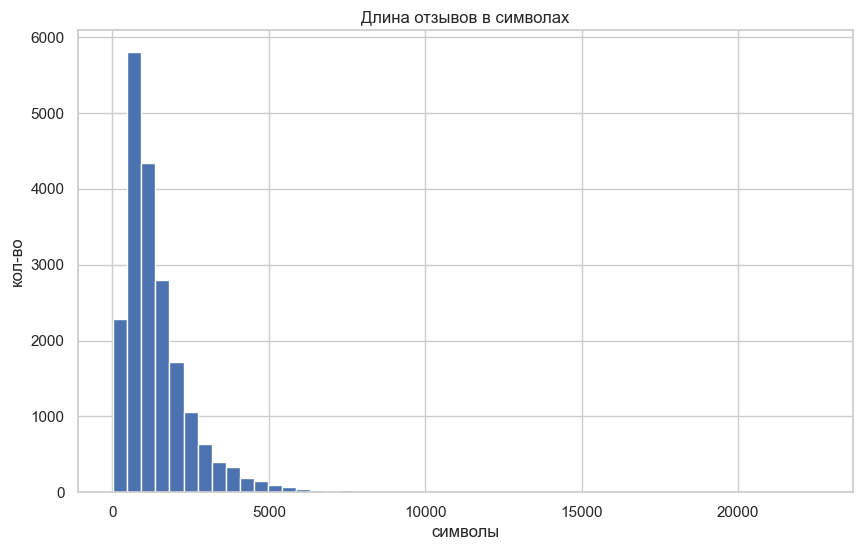

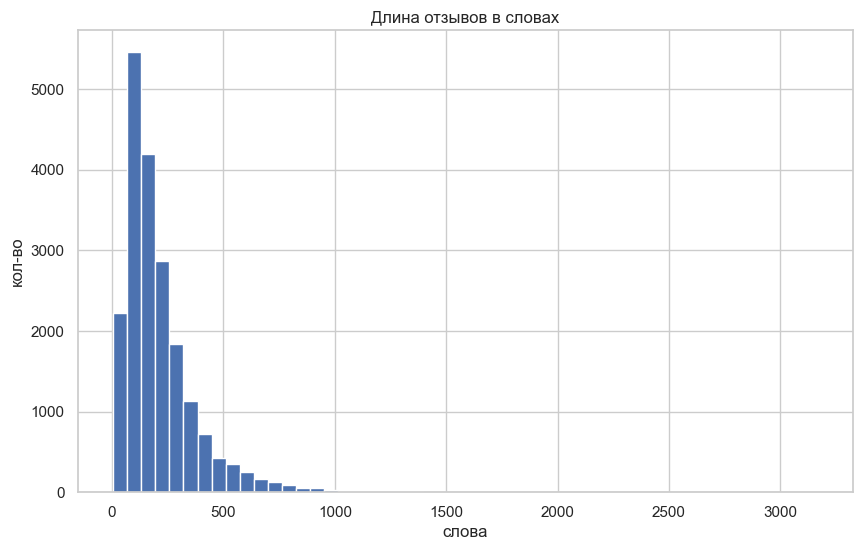


10 самых частых слов:
[('в', 161996), ('и', 130687), ('не', 103028), ('на', 85205), ('что', 77133), ('я', 69781), ('с', 56882), ('по', 46049), ('мне', 38528), ('банка', 34262)]

10 самых частых слов без стоп-слов:
[('банка', 34262), ('банк', 27636), ('это', 22502), ('деньги', 15561), ('карту', 12582), ('карты', 11851), ('кредит', 10981), ('день', 9267), ('т', 9241), ('банке', 9168)]

Лемматизация (ускоренная с swifter)...


Pandas Apply: 100%|███████████████████████| 20103/20103 [10:52<00:00, 30.83it/s]



10 самых частых лемм:
[('в', 165063), ('я', 135559), ('и', 130687), ('не', 103028), ('на', 85205), ('банк', 84565), ('что', 80016), ('с', 64154), ('быть', 53323), ('по', 46049)]

Извлечение существительных (ускоренное)...


Pandas Apply: 100%|███████████████████████| 20103/20103 [10:56<00:00, 30.60it/s]



10 самых частых существительных:
[('банк', 84565), ('карта', 39489), ('деньга', 21409), ('кредит', 21154), ('день', 20755), ('клиент', 17217), ('счёт', 17193), ('сотрудник', 16846), ('отделение', 16749), ('сумма', 13915)]


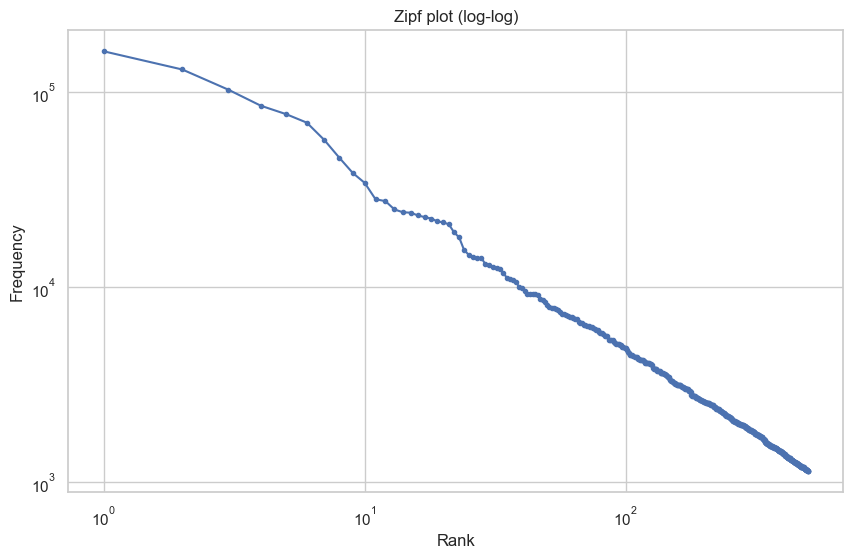

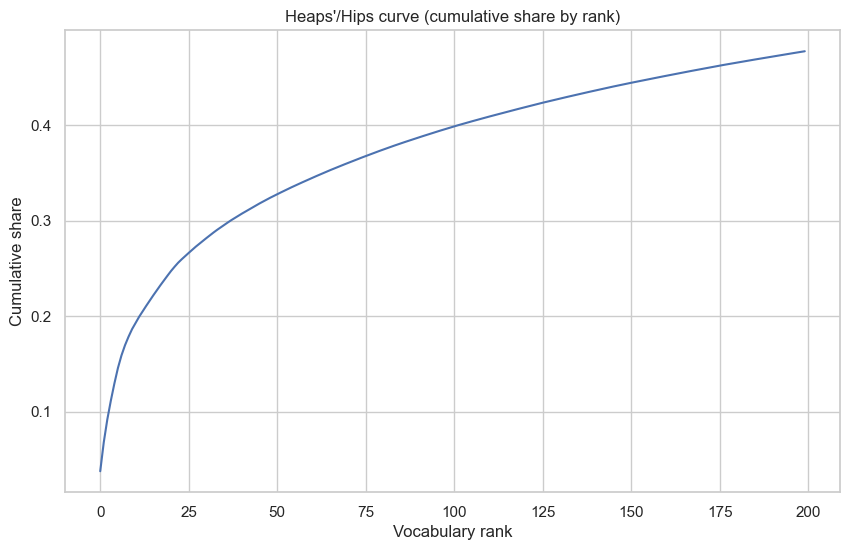

Слово 'сотрудник' встречается: 3857 раз(а)
Слово 'клиент' встречается: 2490 раз(а)
Слово 'мошенничество' встречается: 141 раз(а)
Слово 'доверие' встречается: 155 раз(а)

Top tf-idf для rating=5 (унограмы+биграмы):
[('в', 0.06821038132767346), ('и', 0.06776250670428702), ('не', 0.03857031557020718), ('на', 0.03802416486061361), ('что', 0.03146392614363376), ('я', 0.03084290737795364), ('с', 0.030819939358621422), ('по', 0.024821353998604027), ('банка', 0.022424597864001874), ('все', 0.021570370845399384), ('за', 0.020625996328123185), ('банк', 0.019755443799974078), ('очень', 0.019677116062766932), ('мне', 0.019385444748204556), ('как', 0.01820588077408534), ('но', 0.017371286409910886), ('а', 0.017205406880021215), ('к', 0.017066211816573577), ('меня', 0.01642023394639691), ('у', 0.014834801055445535), ('то', 0.014744895088238725), ('это', 0.014705603282177324), ('так', 0.013902465301391774), ('для', 0.013651869554104096), ('было', 0.012963757469639806), ('спасибо', 0.01294064561702295

In [7]:
# Подготовка для tqdm
tqdm.pandas()

# 1. Топ городов и банков
print('\nТоп городов:')
print(df['city'].value_counts().head(20))
print('\nТоп банков:')
print(df['bank'].value_counts().head(20))

# 2. Длины отзывов
df['len_chars'] = df['text'].str.len()

# Токенизация слов (русский)
def tokenize(text):
    return TOKEN_RE.findall(text.lower())

df['tokens'] = df['text'].progress_apply(tokenize)
df['len_words'] = df['tokens'].apply(len)

# Гистограммы
plt.figure()
plt.hist(df['len_chars'], bins=50)
plt.title('Длина отзывов в символах')
plt.xlabel('символы')
plt.ylabel('кол-во')
plt.show()

plt.figure()
plt.hist(df['len_words'], bins=50)
plt.title('Длина отзывов в словах')
plt.xlabel('слова')
plt.ylabel('кол-во')
plt.show()

# 3. Частые слова
all_words = [w for toks in df['tokens'] for w in toks]
word_counts = Counter(all_words)
print('\n10 самых частых слов:')
print(word_counts.most_common(10))

# Без стоп-слов
words_no_stop = [w for w in all_words if w not in RUS_STOPWORDS]
no_stop_counts = Counter(words_no_stop)
print('\n10 самых частых слов без стоп-слов:')
print(no_stop_counts.most_common(10))

# 4. Лемматизация
def lemmatize_tokens(tokens):
    lemmas = []
    for t in tokens:
        p = MORPH.parse(t)[0]
        lemmas.append(p.normal_form)
    return lemmas

print('\nЛемматизация...')

df['lemmas'] = df['tokens'].swifter.apply(lemmatize_tokens)
all_lemmas = [l for lem in df['lemmas'] for l in lem]
lemma_counts = Counter(all_lemmas)
print('\n10 самых частых лемм:')
print(lemma_counts.most_common(10))

# 5. Извлечение существительных с ускорением
def nouns_from_tokens(tokens):
    nouns = []
    for t in tokens:
        p = MORPH.parse(t)[0]
        if 'NOUN' in p.tag:
            nouns.append(p.normal_form)
    return nouns

print('\nИзвлечение существительных...')

df['nouns'] = df['tokens'].swifter.apply(nouns_from_tokens)
all_nouns = [n for ns in df['nouns'] for n in ns]
noun_counts = Counter(all_nouns)
print('\n10 самых частых существительных:')
print(noun_counts.most_common(10))

# 6. Zipf plot
def plot_zipf(counter, top_n=200):
    items = counter.most_common(top_n)
    freqs = np.array([c for _, c in items])
    ranks = np.arange(1, len(freqs)+1)
    plt.figure()
    plt.loglog(ranks, freqs, marker='.')
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.title('Zipf plot (log-log)')
    plt.show()

plot_zipf(word_counts, top_n=500)

# 7. Heaps/Hip's curve
def plot_hips(counter):
    items = counter.most_common()
    freqs = np.array([c for _, c in items])
    cum = np.cumsum(freqs) / freqs.sum()
    plt.figure()
    plt.plot(cum[:200])
    plt.xlabel('Vocabulary rank')
    plt.ylabel('Cumulative share')
    plt.title("Heaps'/Hips curve (cumulative share by rank)")
    plt.show()

plot_hips(word_counts)

# 8. Частоты конкретных слов
for w in ['сотрудник', 'клиент', 'мошенничество', 'доверие']:
    print(f"Слово '{w}' встречается: {word_counts[w]} раз(а)")

# 9. TF-IDF для rating 5 и 1
def top_tfidf_for_class(texts, top_n=30, ngram_range=(1,2)):
    vec = TfidfVectorizer(ngram_range=ngram_range, min_df=2, token_pattern=r"[а-яёА-ЯЁ]+")
    X = vec.fit_transform(texts)
    mean_tfidf = np.asarray(X.mean(axis=0)).ravel()
    idx = np.argsort(mean_tfidf)[::-1][:top_n]
    features = np.array(vec.get_feature_names_out())
    return list(zip(features[idx], mean_tfidf[idx]))

texts5 = df[df['rating_grade']==5]['text'].astype(str).tolist()
texts1 = df[df['rating_grade']==1]['text'].astype(str).tolist()

print('\nTop tf-idf для rating=5 (унограмы+биграмы):')
if len(texts5) > 0:
    print(top_tfidf_for_class(texts5, top_n=30))
else:
    print('Нет примеров рейтинга 5')

print('\nTop tf-idf для rating=1 (унограмы+биграмы):')
if len(texts1) > 0:
    print(top_tfidf_for_class(texts1, top_n=30))
else:
    print('Нет примеров рейтинга 1')

## Часть 2. Тематическое моделирование

In [8]:
# Gensim LDA: подготовка корпуса
print('\nГотовим корпус для тематического моделирования...')
texts_for_topics = df['lemmas'].tolist()
# Фильтруем стоп-слова
texts_for_topics = [[w for w in doc if w not in RUS_STOPWORDS and len(w)>1] for doc in texts_for_topics]

# Создаём словарь и корпус
id2word = corpora.Dictionary(texts_for_topics)
id2word.filter_extremes(no_below=5, no_above=0.5)
corpus = [id2word.doc2bow(text) for text in texts_for_topics]

# Подбор числа тем: попробуем 5, 10, 15
lda_models = {}
for num_topics in [5, 10, 15]:
    print(f'Обучаю gensim LDA на {num_topics} темах...')
    model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=5, random_state=42)
    lda_models[num_topics] = model
    for t in range(num_topics):
        print(f'Topic {t}:', model.print_topic(t, 8))
    print('\n')

# Найдём темы, где упоминаются конкретные банки
bank_terms = ['сбербанк', 'втб', 'сбер', 'альфа', 'тинькофф']
for k, model in lda_models.items():
    print(f'--- Модель {k} тем. Ищем банки:')
    for t in range(k):
        topic_str = model.print_topic(t, 30)
        for bt in bank_terms:
            if bt in topic_str:
                print(f'В теме {t} упоминается {bt}:', topic_str)




Готовим корпус для тематического моделирования...
Обучаю gensim LDA на 5 темах...
Topic 0: 0.020*"вклад" + 0.017*"клиент" + 0.013*"отделение" + 0.011*"офис" + 0.010*"очень" + 0.009*"сотрудник" + 0.008*"очередь" + 0.008*"весь"
Topic 1: 0.051*"карта" + 0.019*"деньга" + 0.014*"счёт" + 0.010*"банкомат" + 0.008*"мочь" + 0.008*"отделение" + 0.007*"заявление" + 0.007*"операция"
Topic 2: 0.013*"звонить" + 0.013*"телефон" + 0.012*"номер" + 0.011*"сотрудник" + 0.011*"звонок" + 0.011*"человек" + 0.010*"ваш" + 0.008*"сказать"
Topic 3: 0.015*"сумма" + 0.015*"платёж" + 0.014*"договор" + 0.013*"заявление" + 0.012*"счёт" + 0.010*"средство" + 0.009*"кредитный" + 0.009*"сотрудник"
Topic 4: 0.040*"кредит" + 0.013*"документ" + 0.013*"заявка" + 0.011*"кредитный" + 0.010*"сказать" + 0.008*"сумма" + 0.007*"год" + 0.007*"договор"


Обучаю gensim LDA на 10 темах...
Topic 0: 0.017*"клиент" + 0.016*"договор" + 0.014*"сотрудник" + 0.011*"вклад" + 0.010*"информация" + 0.010*"который" + 0.008*"лицо" + 0.008*"свой"

## Часть 3. Классификация текстов

In [9]:
# Параметры: число примеров каждого класса
N1 = 2000
N2 = 2000

# Берём available
class1 = df[df['rating_grade']==1]
class5 = df[df['rating_grade']==5]

n1 = min(N1, len(class1))
n2 = min(N2, len(class5))
print(f'Используем {n1} примеров класса 1 и {n2} примеров класса 5')

df_sub = pd.concat([class1.sample(n=n1, random_state=42), class5.sample(n=n2, random_state=42)])

df_sub = df_sub.sample(frac=1, random_state=42).reset_index(drop=True)
X = df_sub['text'].astype(str)
y = (df_sub['rating_grade']==5).astype(int)  # 1 — положительный

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Сравнение векторизаций: TfidfVectorizer с разными ngram_range и CharNGram

vectorizer_options = {
    'unigrams': TfidfVectorizer(ngram_range=(1,1), token_pattern=r"[а-яёА-ЯЁ]+", min_df=2),
    'bigrams': TfidfVectorizer(ngram_range=(1,2), token_pattern=r"[а-яёА-ЯЁ]+", min_df=2),
    'trigrams': TfidfVectorizer(ngram_range=(1,3), token_pattern=r"[а-яёА-ЯЁ]+", min_df=2),
    'char_3_5': TfidfVectorizer(analyzer='char', ngram_range=(3,5), min_df=2)
}

results = []
for name, vec in vectorizer_options.items():
    print(f'Обучение классификатора с векторизацией: {name}')
    Xtr = vec.fit_transform(X_train)
    Xte = vec.transform(X_test)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(Xtr, y_train)
    ypred = clf.predict(Xte)
    acc = accuracy_score(y_test, ypred)
    f1 = f1_score(y_test, ypred)
    print(f'-> accuracy={acc:.4f}, f1={f1:.4f}')
    results.append((name, acc, f1))

print('\nРезультаты сравнений векторизаций:')
print(pd.DataFrame(results, columns=['vectorizer','accuracy','f1']).sort_values('f1', ascending=False))

# Теперь добавим признаки скрытых тем
# Вариант 1: TF-IDF + TruncatedSVD
vec = TfidfVectorizer(ngram_range=(1,2), token_pattern=r"[а-яёА-ЯЁ]+", min_df=2)
Xtr_tfidf = vec.fit_transform(X_train)
Xte_tfidf = vec.transform(X_test)

svd = TruncatedSVD(n_components=100, random_state=42)
Xtr_svd = svd.fit_transform(Xtr_tfidf)
Xte_svd = svd.transform(Xte_tfidf)

clf = LogisticRegression(max_iter=1000)
clf.fit(Xtr_svd, y_train)
ypred = clf.predict(Xte_svd)
print('\nTF-IDF + TruncatedSVD ->', 'acc', accuracy_score(y_test, ypred), 'f1', f1_score(y_test, ypred))

# Вариант 2: LDA как признаки (sklearn LatentDirichletAllocation)

vec_count = CountVectorizer(ngram_range=(1,2), token_pattern=r"[а-яёА-ЯЁ]+", min_df=2)
Xtr_count = vec_count.fit_transform(X_train)
Xte_count = vec_count.transform(X_test)

lda = LatentDirichletAllocation(n_components=20, random_state=42)
Xtr_lda = lda.fit_transform(Xtr_count)
Xte_lda = lda.transform(Xte_count)

clf.fit(Xtr_lda, y_train)
ypred = clf.predict(Xte_lda)
print('LDA-topics ->', 'acc', accuracy_score(y_test, ypred), 'f1', f1_score(y_test, ypred))

# Сравним все три показателя
print('\nСводка:')
print('TF-IDF+SVD and LDA сравнение показано выше.')

# Сохраним модель/векторизаторы при желании
# Например, сохранить vec, clf, svd с помощью joblib

print('\nEnddd ;))))')


Используем 2000 примеров класса 1 и 2000 примеров класса 5
Обучение классификатора с векторизацией: unigrams
-> accuracy=0.9300, f1=0.9286
Обучение классификатора с векторизацией: bigrams
-> accuracy=0.9180, f1=0.9165
Обучение классификатора с векторизацией: trigrams
-> accuracy=0.9200, f1=0.9182
Обучение классификатора с векторизацией: char_3_5
-> accuracy=0.9350, f1=0.9332

Результаты сравнений векторизаций:
  vectorizer  accuracy        f1
3   char_3_5     0.935  0.933196
0   unigrams     0.930  0.928571
2   trigrams     0.920  0.918200
1    bigrams     0.918  0.916497

TF-IDF + TruncatedSVD -> acc 0.913 f1 0.9116751269035535
LDA-topics -> acc 0.856 f1 0.8396436525612473

Сводка:
TF-IDF+SVD and LDA сравнение показано выше.

Enddd
